# Optional Lab: Logistic Regression, Decision Boundary


## Goals
In this lab, you will:
- Plot the decision boundary for a logistic regression model. This will give you a better sense of what the model is predicting.


In [2]:
"""
lab_utils_common
   contains common routines and variable definitions
   used by all the labs in this week.
   by contrast, specific, large plotting routines will be in separate files
   and are generally imported into the week where they are used.
   those files will import this file
"""
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from ipywidgets import Output

np.set_printoptions(precision=2)

dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]
#plt.style.use('./deeplearning.mplstyle')

def sigmoid(z):
    """
    Compute the sigmoid of z

    Parameters
    ----------
    z : array_like
        A scalar or numpy array of any size.

    Returns
    -------
     g : array_like
         sigmoid(z)
    """
    z = np.clip( z, -500, 500 )           # protect against overflow
    g = 1.0/(1.0+np.exp(-z))

    return g

##########################################################
# Regression Routines
##########################################################

def predict_logistic(X, w, b):
    """ performs prediction """
    return sigmoid(X @ w + b)

def predict_linear(X, w, b):
    """ performs prediction """
    return X @ w + b

def compute_cost_logistic(X, y, w, b, lambda_=0, safe=False):
    """
    Computes cost using logistic loss, non-matrix version

    Args:
      X (ndarray): Shape (m,n)  matrix of examples with n features
      y (ndarray): Shape (m,)   target values
      w (ndarray): Shape (n,)   parameters for prediction
      b (scalar):               parameter  for prediction
      lambda_ : (scalar, float) Controls amount of regularization, 0 = no regularization
      safe : (boolean)          True-selects under/overflow safe algorithm
    Returns:
      cost (scalar): cost
    """

    m,n = X.shape
    cost = 0.0
    for i in range(m):
        z_i    = np.dot(X[i],w) + b                                             #(n,)(n,) or (n,) ()
        if safe:  #avoids overflows
            cost += -(y[i] * z_i ) + log_1pexp(z_i)
        else:
            f_wb_i = sigmoid(z_i)                                                   #(n,)
            cost  += -y[i] * np.log(f_wb_i) - (1 - y[i]) * np.log(1 - f_wb_i)       # scalar
    cost = cost/m

    reg_cost = 0
    if lambda_ != 0:
        for j in range(n):
            reg_cost += (w[j]**2)                                               # scalar
        reg_cost = (lambda_/(2*m))*reg_cost

    return cost + reg_cost


def log_1pexp(x, maximum=20):
    ''' approximate log(1+exp^x)
        https://stats.stackexchange.com/questions/475589/numerical-computation-of-cross-entropy-in-practice
    Args:
    x   : (ndarray Shape (n,1) or (n,)  input
    out : (ndarray Shape matches x      output ~= np.log(1+exp(x))
    '''

    out  = np.zeros_like(x,dtype=float)
    i    = x <= maximum
    ni   = np.logical_not(i)

    out[i]  = np.log(1 + np.exp(x[i]))
    out[ni] = x[ni]
    return out


def compute_cost_matrix(X, y, w, b, logistic=False, lambda_=0, safe=True):
    """
    Computes the cost using  using matrices
    Args:
      X : (ndarray, Shape (m,n))          matrix of examples
      y : (ndarray  Shape (m,) or (m,1))  target value of each example
      w : (ndarray  Shape (n,) or (n,1))  Values of parameter(s) of the model
      b : (scalar )                       Values of parameter of the model
      verbose : (Boolean) If true, print out intermediate value f_wb
    Returns:
      total_cost: (scalar)                cost
    """
    m = X.shape[0]
    y = y.reshape(-1,1)             # ensure 2D
    w = w.reshape(-1,1)             # ensure 2D
    if logistic:
        if safe:  #safe from overflow
            z = X @ w + b                                                           #(m,n)(n,1)=(m,1)
            cost = -(y * z) + log_1pexp(z)
            cost = np.sum(cost)/m                                                   # (scalar)
        else:
            f    = sigmoid(X @ w + b)                                               # (m,n)(n,1) = (m,1)
            cost = (1/m)*(np.dot(-y.T, np.log(f)) - np.dot((1-y).T, np.log(1-f)))   # (1,m)(m,1) = (1,1)
            cost = cost[0,0]                                                        # scalar
    else:
        f    = X @ w + b                                                        # (m,n)(n,1) = (m,1)
        cost = (1/(2*m)) * np.sum((f - y)**2)                                   # scalar

    reg_cost = (lambda_/(2*m)) * np.sum(w**2)                                   # scalar

    total_cost = cost + reg_cost                                                # scalar

    return total_cost                                                           # scalar

def compute_gradient_matrix(X, y, w, b, logistic=False, lambda_=0):
    """
    Computes the gradient using matrices

    Args:
      X : (ndarray, Shape (m,n))          matrix of examples
      y : (ndarray  Shape (m,) or (m,1))  target value of each example
      w : (ndarray  Shape (n,) or (n,1))  Values of parameters of the model
      b : (scalar )                       Values of parameter of the model
      logistic: (boolean)                 linear if false, logistic if true
      lambda_:  (float)                   applies regularization if non-zero
    Returns
      dj_dw: (array_like Shape (n,1))     The gradient of the cost w.r.t. the parameters w
      dj_db: (scalar)                     The gradient of the cost w.r.t. the parameter b
    """
    m = X.shape[0]
    y = y.reshape(-1,1)             # ensure 2D
    w = w.reshape(-1,1)             # ensure 2D

    f_wb  = sigmoid( X @ w + b ) if logistic else  X @ w + b      # (m,n)(n,1) = (m,1)
    err   = f_wb - y                                              # (m,1)
    dj_dw = (1/m) * (X.T @ err)                                   # (n,m)(m,1) = (n,1)
    dj_db = (1/m) * np.sum(err)                                   # scalar

    dj_dw += (lambda_/m) * w        # regularize                  # (n,1)

    return dj_db, dj_dw                                           # scalar, (n,1)

def gradient_descent(X, y, w_in, b_in, alpha, num_iters, logistic=False, lambda_=0, verbose=True):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X (ndarray):    Shape (m,n)         matrix of examples
      y (ndarray):    Shape (m,) or (m,1) target value of each example
      w_in (ndarray): Shape (n,) or (n,1) Initial values of parameters of the model
      b_in (scalar):                      Initial value of parameter of the model
      logistic: (boolean)                 linear if false, logistic if true
      lambda_:  (float)                   applies regularization if non-zero
      alpha (float):                      Learning rate
      num_iters (int):                    number of iterations to run gradient descent

    Returns:
      w (ndarray): Shape (n,) or (n,1)    Updated values of parameters; matches incoming shape
      b (scalar):                         Updated value of parameter
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    w = w.reshape(-1,1)      #prep for matrix operations
    y = y.reshape(-1,1)

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = compute_gradient_matrix(X, y, w, b, logistic, lambda_)

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history.append( compute_cost_matrix(X, y, w, b, logistic, lambda_) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            if verbose: print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")

    return w.reshape(w_in.shape), b, J_history  #return final w,b and J history for graphing

def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column

    Args:
      X (ndarray): Shape (m,n) input data, m examples, n features

    Returns:
      X_norm (ndarray): Shape (m,n)  input normalized by column
      mu (ndarray):     Shape (n,)   mean of each feature
      sigma (ndarray):  Shape (n,)   standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

#check our work
#from sklearn.preprocessing import scale
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)

######################################################
# Common Plotting Routines
######################################################


def plot_data(X, y, ax, pos_label="y=1", neg_label="y=0", s=80, loc='best' ):
    """ plots logistic data with two axis """
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0
    pos = pos.reshape(-1,)  #work with 1D or 1D y vectors
    neg = neg.reshape(-1,)

    # Plot examples
    ax.scatter(X[pos, 0], X[pos, 1], marker='x', s=s, c = 'red', label=pos_label)
    ax.scatter(X[neg, 0], X[neg, 1], marker='o', s=s, label=neg_label, facecolors='none', edgecolors=dlblue, lw=3)
    ax.legend(loc=loc)

    ax.figure.canvas.toolbar_visible = False
    ax.figure.canvas.header_visible = False
    ax.figure.canvas.footer_visible = False

def plt_tumor_data(x, y, ax):
    """ plots tumor data on one axis """
    pos = y == 1
    neg = y == 0

    ax.scatter(x[pos], y[pos], marker='x', s=80, c = 'red', label="malignant")
    ax.scatter(x[neg], y[neg], marker='o', s=100, label="benign", facecolors='none', edgecolors=dlblue,lw=3)
    ax.set_ylim(-0.175,1.1)
    ax.set_ylabel('y')
    ax.set_xlabel('Tumor Size')
    ax.set_title("Logistic Regression on Categorical Data")

    ax.figure.canvas.toolbar_visible = False
    ax.figure.canvas.header_visible = False
    ax.figure.canvas.footer_visible = False

# Draws a threshold at 0.5
def draw_vthresh(ax,x):
    """ draws a threshold """
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    ax.fill_between([xlim[0], x], [ylim[1], ylim[1]], alpha=0.2, color=dlblue)
    ax.fill_between([x, xlim[1]], [ylim[1], ylim[1]], alpha=0.2, color=dldarkred)
    ax.annotate("z >= 0", xy= [x,0.5], xycoords='data',
                xytext=[30,5],textcoords='offset points')
    d = FancyArrowPatch(
        posA=(x, 0.5), posB=(x+3, 0.5), color=dldarkred,
        arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
    )
    ax.add_artist(d)
    ax.annotate("z < 0", xy= [x,0.5], xycoords='data',
                 xytext=[-50,5],textcoords='offset points', ha='left')
    f = FancyArrowPatch(
        posA=(x, 0.5), posB=(x-3, 0.5), color=dlblue,
        arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
    )
    ax.add_artist(f)

In [3]:
import time
import copy
from ipywidgets import Output
from matplotlib.widgets import Button, CheckButtons
from matplotlib.patches import FancyArrowPatch
#from lab_utils_common import np, plt, dlblue, dlorange, sigmoid, dldarkred, gradient_descent

# for debug
#output = Output() # sends hidden error messages to display when using widgets
#display(output)

class plt_one_addpt_onclick:
    """ class to run one interactive plot """
    def __init__(self, x, y, w, b, logistic=True):
        self.logistic=logistic
        pos = y == 1
        neg = y == 0

        fig,ax = plt.subplots(1,1,figsize=(8,4))
        fig.canvas.toolbar_visible = False
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False

        plt.subplots_adjust(bottom=0.25)
        ax.scatter(x[pos], y[pos], marker='x', s=80, c = 'red', label="malignant")
        ax.scatter(x[neg], y[neg], marker='o', s=100, label="benign", facecolors='none', edgecolors=dlblue,lw=3)
        ax.set_ylim(-0.05,1.1)
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[0],xlim[1]*2)
        ax.set_ylabel('y')
        ax.set_xlabel('Tumor Size')
        self.alegend = ax.legend(loc='lower right')
        if self.logistic:
            ax.set_title("Example of Logistic Regression on Categorical Data")
        else:
            ax.set_title("Example of Linear Regression on Categorical Data")

        ax.text(0.65,0.8,"[Click to add data points]", size=10, transform=ax.transAxes)

        axcalc   = plt.axes([0.1, 0.05, 0.38, 0.075])  #l,b,w,h
        axthresh = plt.axes([0.5, 0.05, 0.38, 0.075])  #l,b,w,h
        self.tlist = []

        self.fig = fig
        self.ax = [ax,axcalc,axthresh]
        self.x = x
        self.y = y
        self.w = copy.deepcopy(w)
        self.b = b
        f_wb = np.matmul(self.x.reshape(-1,1), self.w) + self.b
        if self.logistic:
            self.aline = self.ax[0].plot(self.x, sigmoid(f_wb), color=dlblue)
            self.bline = self.ax[0].plot(self.x, f_wb, color=dlorange,lw=1)
        else:
            self.aline = self.ax[0].plot(self.x, sigmoid(f_wb), color=dlblue)

        self.cid = fig.canvas.mpl_connect('button_press_event', self.add_data)
        if self.logistic:
            self.bcalc = Button(axcalc, 'Run Logistic Regression (click)', color=dlblue)
            self.bcalc.on_clicked(self.calc_logistic)
        else:
            self.bcalc = Button(axcalc, 'Run Linear Regression (click)', color=dlblue)
            self.bcalc.on_clicked(self.calc_linear)
        self.bthresh = CheckButtons(axthresh, ('Toggle 0.5 threshold (after regression)',))
        self.bthresh.on_clicked(self.thresh)
        self.resize_sq(self.bthresh)

 #   @output.capture()  # debug
    def add_data(self, event):
        #self.ax[0].text(0.1,0.1, f"in onclick")
        if event.inaxes == self.ax[0]:
            x_coord = event.xdata
            y_coord = event.ydata

            if y_coord > 0.5:
                self.ax[0].scatter(x_coord, 1, marker='x', s=80, c = 'red' )
                self.y = np.append(self.y,1)
            else:
                self.ax[0].scatter(x_coord, 0, marker='o', s=100, facecolors='none', edgecolors=dlblue,lw=3)
                self.y = np.append(self.y,0)
            self.x = np.append(self.x,x_coord)
        self.fig.canvas.draw()

#   @output.capture()  # debug
    def calc_linear(self, event):
        if self.bthresh.get_status()[0]:
            self.remove_thresh()
        for it in [1,1,1,1,1,2,4,8,16,32,64,128,256]:
            self.w, self.b, _ = gradient_descent(self.x.reshape(-1,1), self.y.reshape(-1,1),
                                                 self.w.reshape(-1,1), self.b, 0.01, it,
                                                 logistic=False, lambda_=0, verbose=False)
            self.aline[0].remove()
            self.alegend.remove()
            y_hat = np.matmul(self.x.reshape(-1,1), self.w) + self.b
            self.aline = self.ax[0].plot(self.x, y_hat, color=dlblue,
                                         label=f"y = {np.squeeze(self.w):0.2f}x+({self.b:0.2f})")
            self.alegend = self.ax[0].legend(loc='lower right')
            time.sleep(0.3)
            self.fig.canvas.draw()
        if self.bthresh.get_status()[0]:
            self.draw_thresh()
            self.fig.canvas.draw()

    def calc_logistic(self, event):
        if self.bthresh.get_status()[0]:
            self.remove_thresh()
        for it in [1, 8,16,32,64,128,256,512,1024,2048,4096]:
            self.w, self.b, _ = gradient_descent(self.x.reshape(-1,1), self.y.reshape(-1,1),
                                                 self.w.reshape(-1,1), self.b, 0.1, it,
                                                 logistic=True, lambda_=0, verbose=False)
            self.aline[0].remove()
            self.bline[0].remove()
            self.alegend.remove()
            xlim  = self.ax[0].get_xlim()
            x_hat = np.linspace(*xlim, 30)
            y_hat = sigmoid(np.matmul(x_hat.reshape(-1,1), self.w) + self.b)
            self.aline = self.ax[0].plot(x_hat, y_hat, color=dlblue,
                                         label="y = sigmoid(z)")
            f_wb = np.matmul(x_hat.reshape(-1,1), self.w) + self.b
            self.bline = self.ax[0].plot(x_hat, f_wb, color=dlorange, lw=1,
                                         label=f"z = {np.squeeze(self.w):0.2f}x+({self.b:0.2f})")
            self.alegend = self.ax[0].legend(loc='lower right')
            time.sleep(0.3)
            self.fig.canvas.draw()
        if self.bthresh.get_status()[0]:
            self.draw_thresh()
            self.fig.canvas.draw()


    def thresh(self, event):
        if self.bthresh.get_status()[0]:
            #plt.figtext(0,0, f"in thresh {self.bthresh.get_status()}")
            self.draw_thresh()
        else:
            #plt.figtext(0,0.3, f"in thresh {self.bthresh.get_status()}")
            self.remove_thresh()

    def draw_thresh(self):
        ws = np.squeeze(self.w)
        xp5 = -self.b/ws if self.logistic else (0.5 - self.b) / ws
        ylim = self.ax[0].get_ylim()
        xlim = self.ax[0].get_xlim()
        a = self.ax[0].fill_between([xlim[0], xp5], [ylim[1], ylim[1]], alpha=0.2, color=dlblue)
        b = self.ax[0].fill_between([xp5, xlim[1]], [ylim[1], ylim[1]], alpha=0.2, color=dldarkred)
        c = self.ax[0].annotate("Malignant", xy= [xp5,0.5], xycoords='data',
             xytext=[30,5],textcoords='offset points')
        d = FancyArrowPatch(
            posA=(xp5, 0.5), posB=(xp5+1.5, 0.5), color=dldarkred,
            arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
        )
        self.ax[0].add_artist(d)

        e = self.ax[0].annotate("Benign", xy= [xp5,0.5], xycoords='data',
                     xytext=[-70,5],textcoords='offset points', ha='left')
        f = FancyArrowPatch(
            posA=(xp5, 0.5), posB=(xp5-1.5, 0.5), color=dlblue,
            arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
        )
        self.ax[0].add_artist(f)
        self.tlist = [a,b,c,d,e,f]

        self.fig.canvas.draw()

    def remove_thresh(self):
        #plt.figtext(0.5,0.0, f"rem thresh {self.bthresh.get_status()}")
        for artist in self.tlist:
            artist.remove()
        self.fig.canvas.draw()

    def resize_sq(self, bcid):
        """ resizes the check box """
        #future reference
        #print(f"width  : {bcid.rectangles[0].get_width()}")
        #print(f"height : {bcid.rectangles[0].get_height()}")
        #print(f"xy     : {bcid.rectangles[0].get_xy()}")
        #print(f"bb     : {bcid.rectangles[0].get_bbox()}")
        #print(f"points : {bcid.rectangles[0].get_bbox().get_points()}")  #[[xmin,ymin],[xmax,ymax]]

        h = bcid.rectangles[0].get_height()
        bcid.rectangles[0].set_height(3*h)

        ymax = bcid.rectangles[0].get_bbox().y1
        ymin = bcid.rectangles[0].get_bbox().y0

        bcid.lines[0][0].set_ydata([ymax,ymin])
        bcid.lines[0][1].set_ydata([ymin,ymax])

In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#from lab_utils_common import plot_data, sigmoid, draw_vthresh
#plt.style.use('./deeplearning.mplstyle')

## Dataset

Let's suppose you have following training dataset
- The input variable `X` is a numpy array which has 6 training examples, each with two features
- The output variable `y` is also a numpy array with 6 examples, and `y` is either `0` or `1`

In [6]:
X = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y = np.array([0, 0, 0, 1, 1, 1]).reshape(-1,1)

In [7]:
X.shape, y.shape

((6, 2), (6, 1))

### Plot data

Let's use a helper function to plot this data. The data points with label $y=1$ are shown as red crosses, while the data points with label $y=0$ are shown as blue circles.

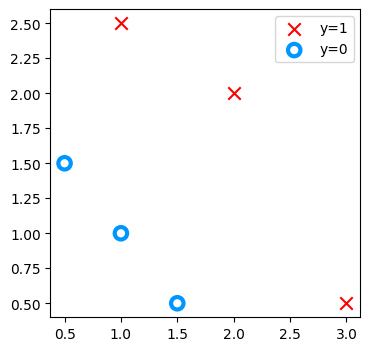

In [13]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_data(X, y, ax)

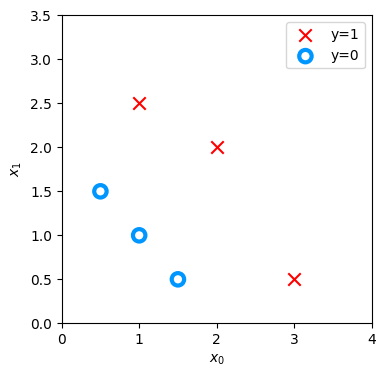

In [21]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_data(X, y, ax)

ax.axis([0, 4, 0, 3.5])
ax.set_ylabel('$x_1$')
ax.set_xlabel(r'$x_0$')
plt.show()

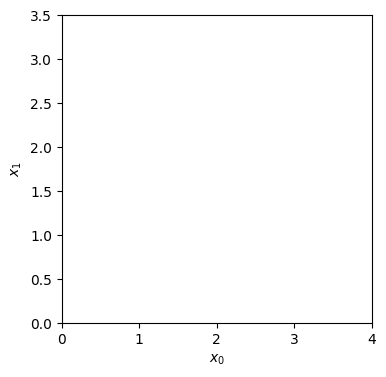

In [22]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.axis([0, 4, 0, 3.5])
ax.set_ylabel('$x_1$')
ax.set_xlabel('$x_0$')
plt.show()

## Logistic regression model


* Suppose you'd like to train a logistic regression model on this data which has the form   

  $f(x) = g(w_0x_0+w_1x_1 + b)$
  
  where $g(z) = \frac{1}{1+e^{-z}}$, which is the sigmoid function


* Let's say that you trained the model and get the parameters as $b = -3, w_0 = 1, w_1 = 1$. That is,

  $f(x) = g(x_0+x_1-3)$

  (You'll learn how to fit these parameters to the data further in the course)
  
  
Let's try to understand what this trained model is predicting by plotting its decision boundary

### Refresher on logistic regression and decision boundary

* Recall that for logistic regression, the model is represented as

  $$f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x}^{(i)} + b) \tag{1}$$

  where $g(z)$ is known as the sigmoid function and it maps all input values to values between 0 and 1:

  $g(z) = \frac{1}{1+e^{-z}}\tag{2}$
  and $\mathbf{w} \cdot \mathbf{x}$ is the vector dot product:
  
  $$\mathbf{w} \cdot \mathbf{x} = w_0 x_0 + w_1 x_1$$
  
  
 * We interpret the output of the model ($f_{\mathbf{w},b}(x)$) as the probability that $y=1$ given $\mathbf{x}$ and parameterized by $\mathbf{w}$ and $b$.
* Therefore, to get a final prediction ($y=0$ or $y=1$) from the logistic regression model, we can use the following heuristic -

  if $f_{\mathbf{w},b}(x) >= 0.5$, predict $y=1$
  
  if $f_{\mathbf{w},b}(x) < 0.5$, predict $y=0$
  
  
* Let's plot the sigmoid function to see where $g(z) >= 0.5$

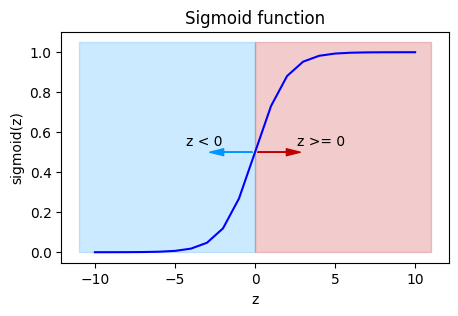

In [23]:
# Plot sigmoid(z) over a range of values from -10 to 10
z = np.arange(-10,11)

fig,ax = plt.subplots(1,1,figsize=(5,3))
# Plot z vs sigmoid(z)
ax.plot(z, sigmoid(z), c="b")

ax.set_title("Sigmoid function")
ax.set_ylabel('sigmoid(z)')
ax.set_xlabel('z')
draw_vthresh(ax,0)

* As you can see, $g(z) >= 0.5$ for $z >=0$

* For a logistic regression model, $z = \mathbf{w} \cdot \mathbf{x} + b$. Therefore,

  if $\mathbf{w} \cdot \mathbf{x} + b >= 0$, the model predicts $y=1$
  
  if $\mathbf{w} \cdot \mathbf{x} + b < 0$, the model predicts $y=0$
  
  
  
### Plotting decision boundary

Now, let's go back to our example to understand how the logistic regression model is making predictions.

* Our logistic regression model has the form

  $f(\mathbf{x}) = g(-3 + x_0+x_1)$


* From what you've learnt above, you can see that this model predicts $y=1$ if $-3 + x_0+x_1 >= 0$

Let's see what this looks like graphically. We'll start by plotting $-3 + x_0+x_1 = 0$, which is equivalent to $x_1 = 3 - x_0$.


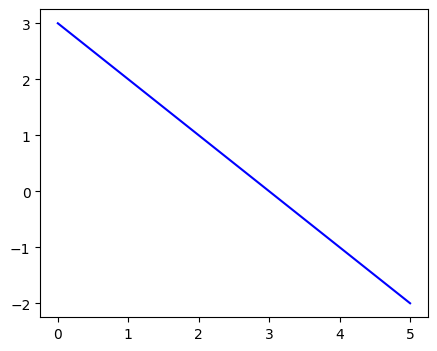

In [25]:
# Choose values between 0 and 6
x0 = np.arange(0,6)

x1 = 3 - x0
fig,ax = plt.subplots(1,1,figsize=(5,4))
# Plot the decision boundary
ax.plot(x0,x1, c="b")

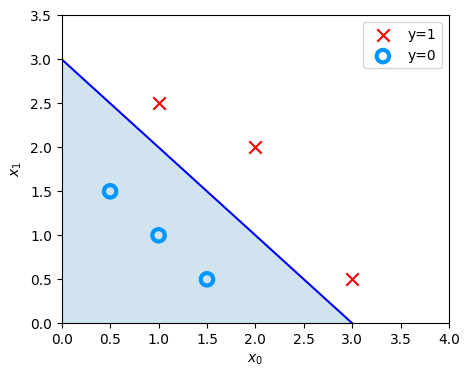

In [24]:
# Choose values between 0 and 6
x0 = np.arange(0,6)

x1 = 3 - x0
fig,ax = plt.subplots(1,1,figsize=(5,4))
# Plot the decision boundary
ax.plot(x0,x1, c="b")
ax.axis([0, 4, 0, 3.5])

# Fill the region below the line
ax.fill_between(x0,x1, alpha=0.2)

# Plot the original data
plot_data(X,y,ax)
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_0$')
plt.show()

* In the plot above, the blue line represents the line $x_0 + x_1 - 3 = 0$ and it should intersect the x1 axis at 3 (if we set $x_1$ = 3, $x_0$ = 0) and the x0 axis at 3 (if we set $x_1$ = 0, $x_0$ = 3).


* The shaded region represents $-3 + x_0+x_1 < 0$. The region above the line is $-3 + x_0+x_1 > 0$.


* Any point in the shaded region (under the line) is classified as $y=0$.  Any point on or above the line is classified as $y=1$. This line is known as the "decision boundary".

As we've seen in the lectures, by using higher order polynomial terms (eg: $f(x) = g( x_0^2 + x_1 -1)$, we can come up with more complex non-linear boundaries.

## Congratulations!
You have explored the decision boundary in the context of logistic regression.